<a href="https://colab.research.google.com/github/MariaZharova/3-day-intensive/blob/main/Dataton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 😼 Практическая часть лекции "Использование готовых предобученных моделей для создания ML-driven продуктов"
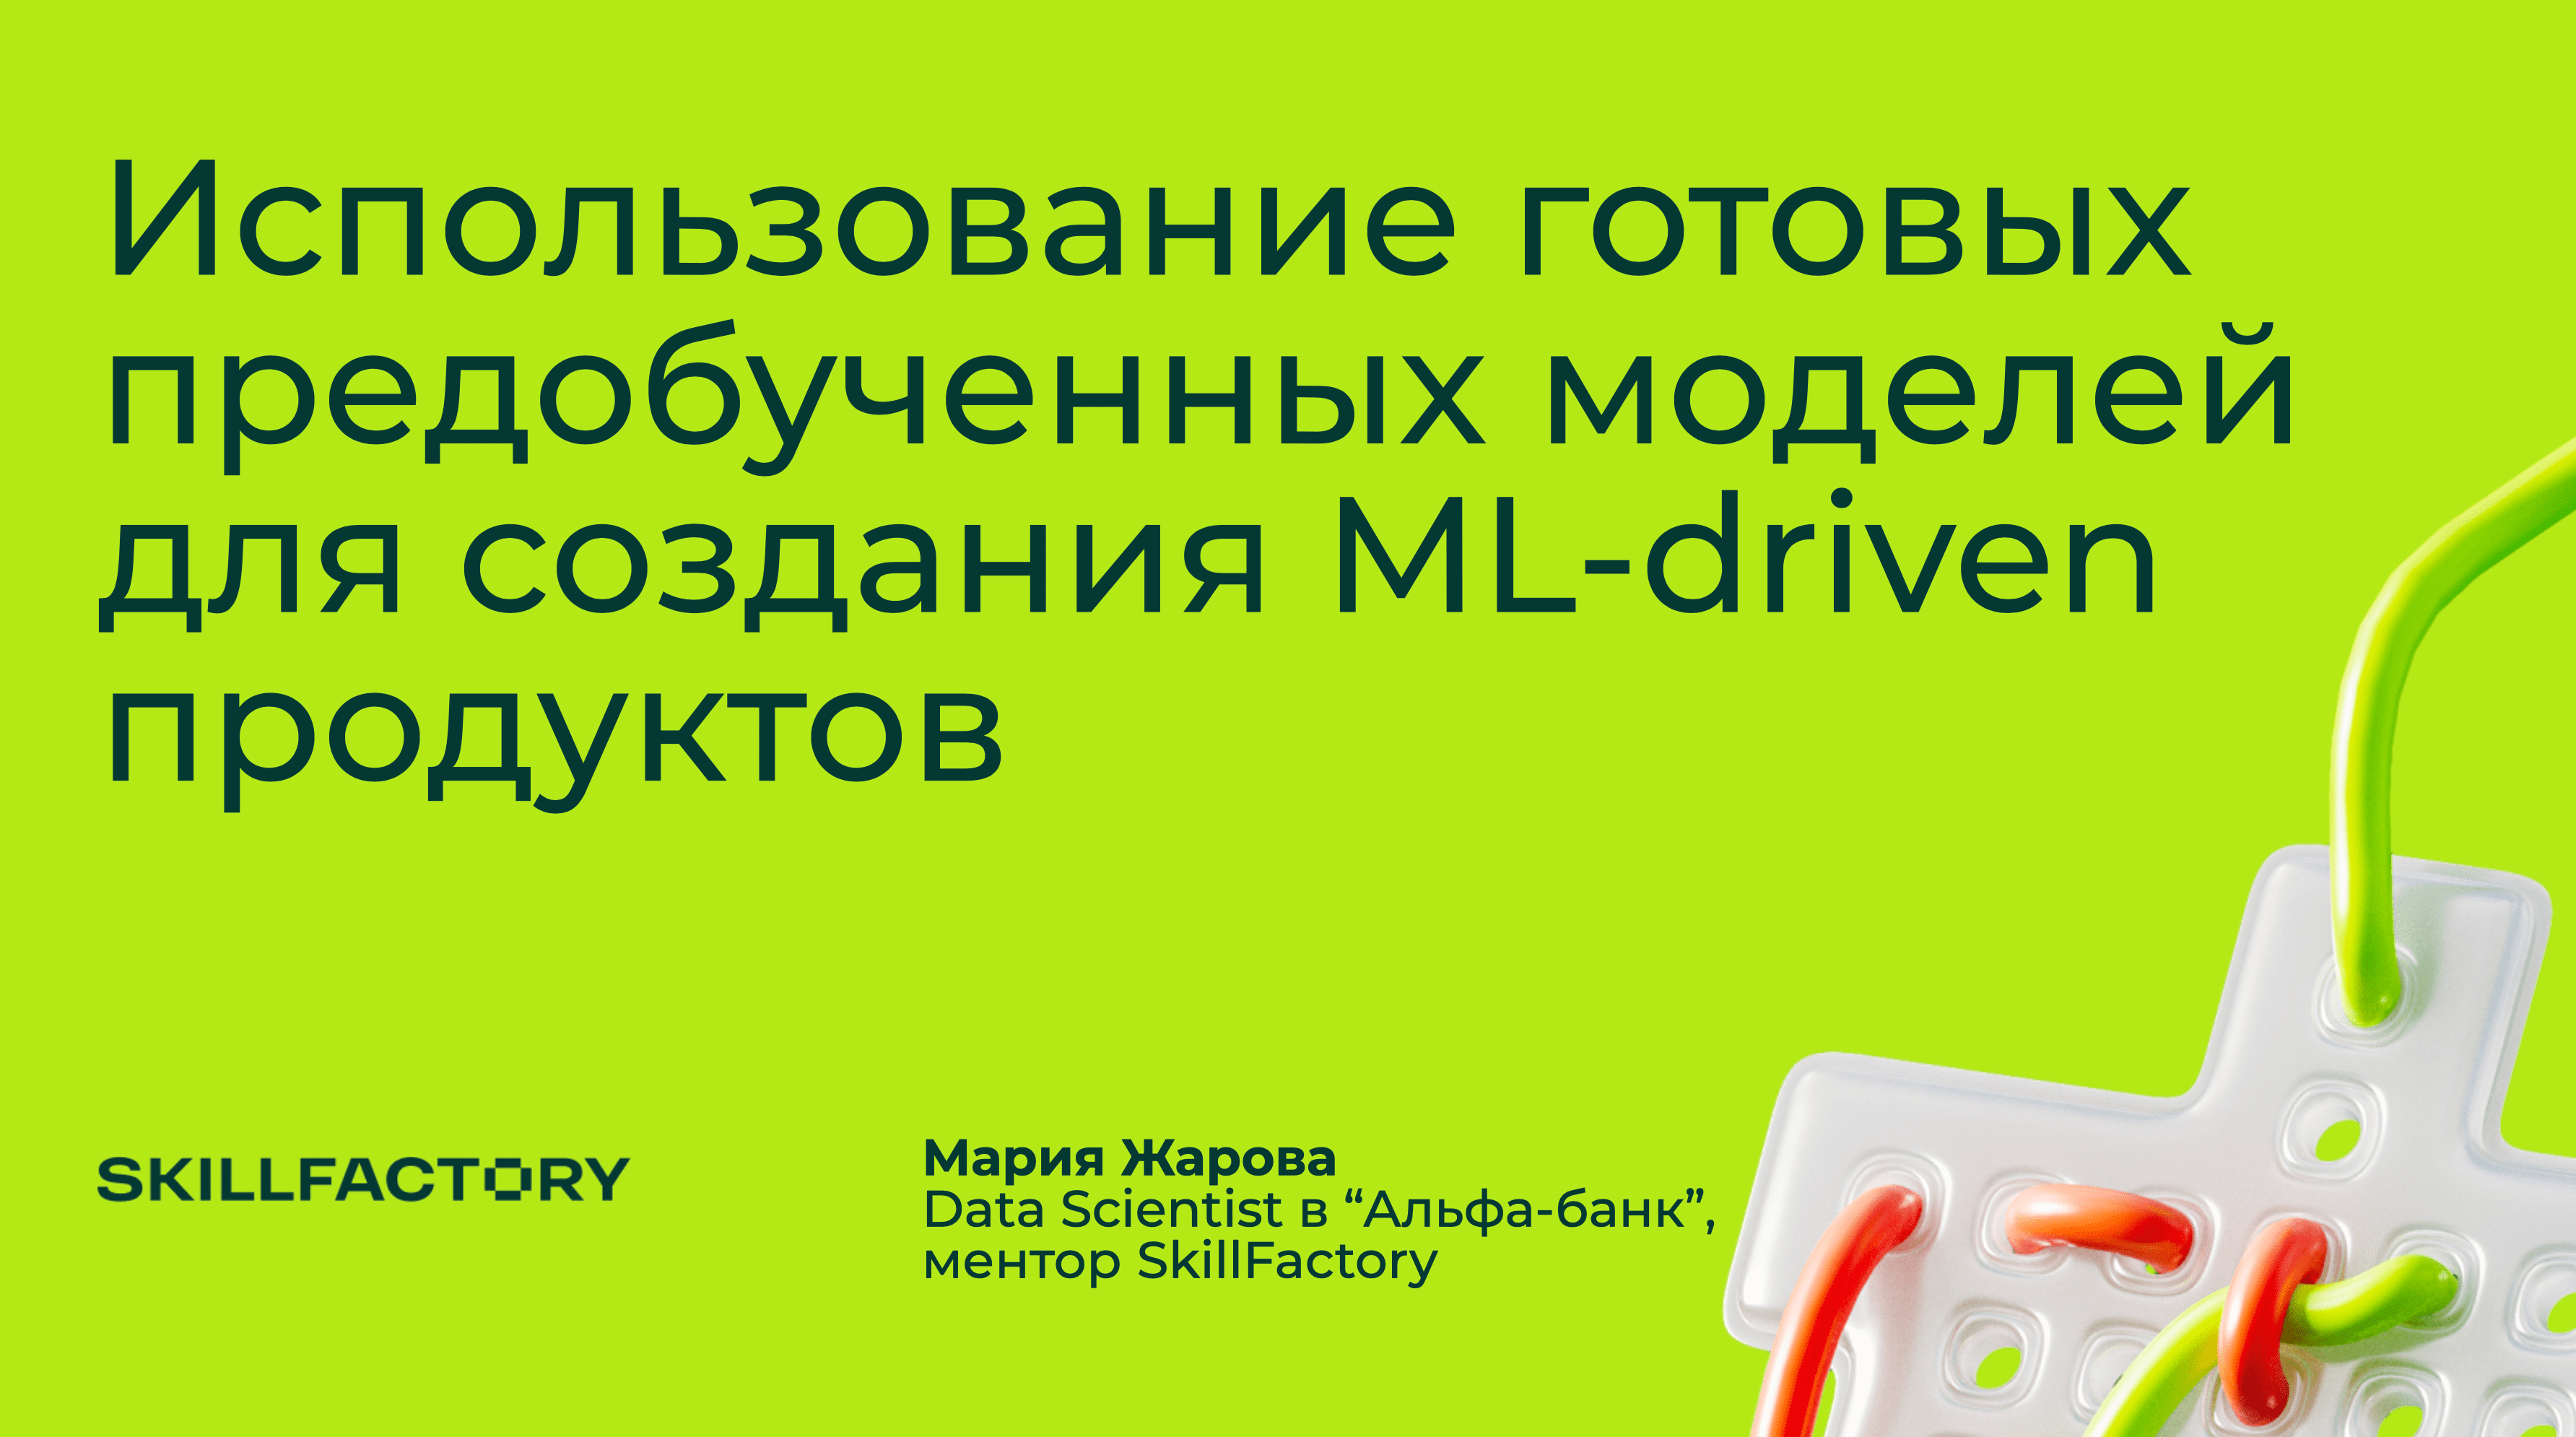

## Поговорим про CV
**Способ 1**: находить предобученные модели в Интернете (например, "SOTA image classification models" - смотрим топ по метрикам, выбираем модель - как правило, все инструкции и веса лежат на GitHub - и дообучаем на своих данных).

💥 Давайте попробуем решить задачу классификации - распознавание людей на фотографии; наша модель будет уметь распознавать Маска, Гейтса, Безоса, Цукерберга и Джобса. Соответствующие датасеты мы уже собрали:)

In [ ]:
import os
import torch
import random
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import shutil
import time
import xml.etree.ElementTree as et

from tqdm import tqdm
from PIL import Image
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
BATCH_SIZE = 32

In [ ]:
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print('Connected device:', device)

musk = 'https://drive.google.com/uc?export=download&id=1BOuq35QzO1YtKQkYGfj_vtBj3Ps5xyBN'
gates ='https://drive.google.com/uc?export=download&id=1jgHQF_NMpH9uMTvic9rGnURu_8UOGdiz'
bezos = 'https://drive.google.com/uc?export=download&id=1n5UaLL-TAkjIeBbTNcn-Czkp_A3Eslhj'
zuker = 'https://drive.google.com/uc?export=download&id=1ncPmYTg6EPHlUFdcjl_bXTbtWRLv2DXy'
jobs = 'https://drive.google.com/uc?export=download&id=1TX3hiRyvSYiYVZUFrbAhN3Jpp9cd0Q9s'

face_lst=[
    ["Elon Musk",'data/musk500.jpg'],
    ["Bill Gates",'data/gates500.jpg'],
    ["Jeff Besoz",'data/bezos500.jpg'],
    ["Mark Zuckerberg", 'data/zuckerberg500.jpg'],
    ["Steve Jobs",'data/jobs500.jpg']
]

Connected device: cuda


In [ ]:
# ! pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a012b512dfee4318cd054f3b5f65f0d9e84aee07efb456cdf3c1a026c3864bff
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
from zipfile import ZipFile

os.mkdir('data')

url = 'https://drive.google.com/uc?export=download&id=120xqh0mYtYZ1Qh7vr-XFzjPbSKivLJjA'
file_name = wget.download(url, 'data/')

with ZipFile(file_name, 'r') as zip_file:
    zip_file.extractall()

link_lst = [musk, gates, bezos, zuker, jobs]
for link in link_lst:
    wget.download(link, 'data/')

In [ ]:
# Training dataset.
train_dataset = ImageFolder(
    root='data/train'
)
# Validation dataset.
valid_dataset = ImageFolder(
    root='data/valid'
)

Добавим аугментаций - автовыравнивание изображений и автоконтраста (чтобы улучшить обобщающую способность моделей и внизить риск переобучения).

In [ ]:
# augmentations
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_dataset.transform = transforms.Compose([
    transforms.Resize([70, 70]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.ToTensor(),
    normalize
])

valid_dataset.transform = transforms.Compose([
    transforms.Resize([70, 70]),
    transforms.ToTensor(),
    normalize
])


In [ ]:
# Training data loaders.
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True
)
# Validation data loaders.
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE,
    shuffle=False
)

Возьмём предобученную нейросеть GoogLeNet.

Меняем выходной параметр `Liner(out_feature=1000)` на количество классов.

Замораживаем все слои, кроме последних двух.

In [ ]:
def google():
    model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(1024, len(train_dataset.classes))
    for param in model.parameters():
        param.requires_grad = True
    model.inception3a.requires_grad = False
    model.inception3b.requires_grad = False
    model.inception4a.requires_grad = False
    model.inception4b.requires_grad = False
    model.inception4c.requires_grad = False
    model.inception4d.requires_grad = False
    model.inception4e.requires_grad = False
    return model

Аналогичный пример для предобученной сети VGG19.

In [ ]:
def vgg_19():
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
    model.classifier[6] = torch.nn.Linear(4096, len(train_dataset.classes))
    for param in model.features.parameters():
        param.requires_grad = False
    for index, block in enumerate(model.features):
        if index >= 30:
            for param in block.parameters():
                param.requires_grad = True
    return model

Определяем функцию обучения модели.

In [ ]:
def train(model, optimizer, train_loader, val_loader, epoch=10):
    loss_train, acc_train = [], []
    loss_valid, acc_valid = [], []
    for epoch in tqdm(range(epoch)):
        losses, equals = [], []
        torch.set_grad_enabled(True)

        # Train.
        model.train()
        for i, (image, target) in enumerate(train_loader):
            image = image.to(device)
            target = target.to(device)
            output = model(image)
            loss = criterion(output,target)

            losses.append(loss.item())
            equals.extend(
                [x.item() for x in torch.argmax(output, 1) == target])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train.append(np.mean(losses))
        acc_train.append(np.mean(equals))
        losses, equals = [], []
        torch.set_grad_enabled(False)

        # Validate.
        model.eval()
        for i , (image, target) in enumerate(valid_loader):
            image = image.to(device)
            target = target.to(device)

            output = model(image)
            loss = criterion(output,target)

            losses.append(loss.item())
            equals.extend(
                [y.item() for y in torch.argmax(output, 1) == target])

        loss_valid.append(np.mean(losses))
        acc_valid.append(np.mean(equals))

    return loss_train, acc_train, loss_valid, acc_valid

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

model = google() # здесь можете заменить на VGG
print('Model: GoogLeNet\n')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)

loss_train, acc_train, loss_valid, acc_valid = train(
model, optimizer, train_loader, valid_loader, 30)
print('acc_train:', acc_train, '\nacc_valid:', acc_valid)
del model
torch.cuda.empty_cache()

Model: GoogLeNet



100%|██████████| 30/30 [03:30<00:00,  7.01s/it]

acc_train: [0.6613333333333333, 0.917, 0.9563333333333334, 0.9696666666666667, 0.9813333333333333, 0.9843333333333333, 0.9903333333333333, 0.9896666666666667, 0.9913333333333333, 0.9916666666666667, 0.995, 0.9946666666666667, 0.9923333333333333, 0.993, 0.998, 0.9933333333333333, 0.9963333333333333, 0.9976666666666667, 0.9976666666666667, 0.9966666666666667, 0.9963333333333333, 0.998, 0.9983333333333333, 0.9963333333333333, 0.9983333333333333, 0.998, 0.9986666666666667, 0.9983333333333333, 0.9976666666666667, 0.999] 
acc_valid: [0.8894967177242888, 0.9573304157549234, 0.9781181619256017, 0.9824945295404814, 0.9770240700218819, 0.9824945295404814, 0.9890590809628009, 0.9890590809628009, 0.9890590809628009, 0.986870897155361, 0.9901531728665208, 0.9901531728665208, 0.9901531728665208, 0.9956236323851203, 0.9923413566739606, 0.9912472647702407, 0.9901531728665208, 0.9934354485776805, 0.9923413566739606, 0.9945295404814004, 0.9912472647702407, 0.9912472647702407, 0.9901531728665208, 0.99562

💥 Рекомендуем рассмотреть ещё один пример задачи CV - детекции, для этого есть отличная популярная модель YOLO-8 (кстати, вот её официальный репозиторий https://github.com/ultralytics/ultralytics - здесь же можно найти туториалы по запуску модели и её дообучения: https://github.com/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb - кода тут гораздо меньше, т.к. модель более продвинутая, писать самостоятельно практически ничего не надо;))

**Способ 2 (3)** Хороший сервис-хранилище предобученных моделей - Roboflow, в нём Вы можете найти множество моделей для различных CV и NLP задач и легко использовать их по API (https://universe.roboflow.com/).

PS: здесь тоже есть вариант использования YOLO https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/

Алгоритм работы с интерфейсом:

1. Зарегистрироваться (можно с аккаунта google)
2. Самое доступное, чем можно воспользоваться - найти готовый проект (страница поиска https://universe.roboflow.com/search?q=nlp) и запустить его "инференс" (например, вот модель детекции цифр на фото https://universe.roboflow.com/alphabettraining/character-detection-iis85/model/2 - внизу находите Hosted API и код как легко запустить модель у себя)
3. То, что нам нужно - *дообучить модели*, для этого нам понадобится аккаунт, пример "дообучения" через веб-интерфейс Roboflow можно посмотреть в туториале про YOLO https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/